# Learning from Yellow Taxi Data

In [31]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans

### Load the data

In [32]:
taxidata = pd.read_csv("./data/test.csv", header=0)

In [33]:
# cleandata = taxidata[(taxidata.pickup_longitude > -74.1) & (taxidata.pickup_longitude < -73.8)]
# cleandata = cleandata[(cleandata.pickup_latitude > 40.55) & (cleandata.pickup_latitude < 40.9)]

# cleandata = cleandata[(cleandata.dropoff_longitude > -74.1) & (cleandata.dropoff_longitude < -73.8)]
# cleandata = cleandata[(cleandata.dropoff_latitude > 40.55) & (cleandata.dropoff_latitude < 40.9)]

cleandata = taxidata

### Define train and test sets

In [34]:
itrain, itest = train_test_split(xrange(cleandata.shape[0]), train_size = 0.8)
mask=np.ones(cleandata.shape[0], dtype='int')
mask[itrain] = 1
mask[itest] = 0
mask = (mask == 1)

### Drop all of the columns except for the pickup and dropoff

In [35]:
X = cleandata[["pickup_longitude", "pickup_latitude"]]
y = cleandata[["dropoff_longitude", "dropoff_latitude"]]

### Cluster the data

In [36]:
# xmatrix = X.as_matrix(columns=X.columns)
# kmeans_x = KMeans(n_clusters=24, n_jobs=-1, random_state=0).fit(xmatrix)
# centroids_x = kmeans_x.predict(xmatrix)
# X = np.array([kmeans_x.cluster_centers_[i] for i in centroids_x])

kmeans_y = KMeans(n_clusters=24, n_jobs=-1, random_state=0).fit(y)
centroids_y = kmeans_y.predict(y)
for i, row in y.iterrows():
    if i < len(y):
        y.set_value(i, "centroid", centroids_y[i])
y = y[["centroid"]]

In [37]:
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
n_samples = Xtrain.shape[0]
n_features = Xtrain.shape[1]

print Xtrain.shape
max_samples = 100
if Xtrain.shape[0] > max_samples:
#     rows = random.sample(range(len(Xtrain)), max_samples)
    rows = random.sample(Xtrain.index, max_samples)
    Xtrain = Xtrain.ix[rows]
    ytrain = ytrain.ix[rows]
print Xtrain.shape

(799, 2)
(100, 2)


### Visualizing the Data

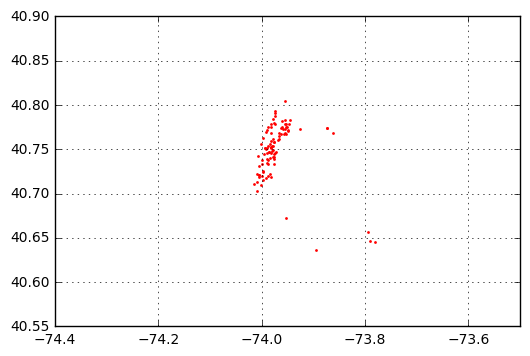

In [38]:
plt.rcParams['agg.path.chunksize'] = 100000
plt.plot(Xtrain["pickup_longitude"], Xtrain["pickup_latitude"], 'ro', markersize=2, markeredgewidth=0)
plt.grid(True)
plt.axis([-74.4, -73.5, 40.55, 40.9])
plt.show()

# plt.plot(ytrain["dropoff_longitude"], ytrain["dropoff_latitude"], 'ro', markersize=2, markeredgewidth=0)
# plt.grid(True)
# plt.axis([-74.4, -73.5, 40.55, 40.9])
# plt.show()

### Optimizing the parameters

In [39]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.cv_results_, gs.scorer_
    print "Best score: ", gs.best_score_
    best = gs.best_estimator_
    return best

In [40]:
# clf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
clf = AdaBoostClassifier(n_estimators=20)

In [49]:
# %%time
# parameters = {
#     "n_estimators": [50],  
#     "max_features": ["auto"],
#     "max_depth": [50]
# }

parameters = {
    "n_estimators": [50],
    "learning_rate": [1]
}

best = cv_optimize(clf, parameters, Xtrain, ytrain.as_matrix().flatten(), n_folds=5, score_func='neg_mean_squared_error', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=50, learning_rate=1 ................................
[CV]  n_estimators=50, learning_rate=1, score=-87.033333, total=   0.2s
[CV] n_estimators=50, learning_rate=1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=50, learning_rate=1, score=-46.681818, total=   0.1s
[CV] n_estimators=50, learning_rate=1 ................................
[CV]  n_estimators=50, learning_rate=1, score=-64.055556, total=   0.1s
[CV] n_estimators=50, learning_rate=1 ................................
[CV]  n_estimators=50, learning_rate=1, score=-67.187500, total=   0.1s
[CV] n_estimators=50, learning_rate=1 ................................
[CV]  n_estimators=50, learning_rate=1, score=-54.000000, total=   0.1s
BEST {'n_estimators': 50, 'learning_rate': 1} -66.22 {'rank_test_score': array([1], dtype=int32), 'std_score_time': array([ 0.00122653]), 'split2_test_score': array([-64.05555556]), 'mean_fit_time': array([ 0.11957507]), 'split3_train_score': array([-60.63095238]), 'std_test_score': array([ 15.35709564]), 'params': ({'n_estimators': 50, 'learning_rate': 1},), 'std_fit_time': array([ 0.01803031]), 'std_train_score': array([ 15.30707293]), 'split4_test_score': array([-54.]), 'split1_train_score':

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


### Train with the data

In [50]:
%%time
reg = best.fit(Xtrain, ytrain)
training_accuracy = reg.score(Xtrain, ytrain)
test_accuracy = reg.score(Xtest, ytest)
print "############# based on standard predict ################"
print "R^2 on training data: %0.4f" % (training_accuracy)
print "R^2 on test data:     %0.4f" % (test_accuracy)

############# based on standard predict ################
R^2 on training data: 0.2400
R^2 on test data:     0.1800
CPU times: user 142 ms, sys: 4.61 ms, total: 147 ms
Wall time: 147 ms


In [14]:
best.predict([[-73.990371704101563, 40.734695434570313]])

array([[-73.98860868,  40.73697467]])